# Compare SEMITONES cell selection across parameter sets
For the selection of reference cells, we submit several job scripts and load the results here. The following parameters are considered. <br>
- cosine similarity, RBF-kernel, euclidean distance
- .1 % of cells, 75 cells, .5% of cells, 1% of cells.
- TF-IDF transformed counts, SVD of 10, 30, 50, 70, 100 dimensions, UMAP of 5, 10, 25, 35, 50 dimensions.

We eveluate the selected cells based on the Hausdorff distance and the fraction of cell types presented in the selected subset. <br>

## 1. Set up the notebook

### a. Load packages

In [2]:
import os
import numpy as np
import pandas as pd
import pickle

from collections import Counter
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.spatial.distance import directed_hausdorff
from SEMITONES.cell_selection import from_knn_dist
from SEMITONES.tfidf import TFIDF
from SEMITONES.support_funcs import load_sparse_h5
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import pairwise_kernels

from scipy.io import mmread
from umap import UMAP

### b. Define scoring functions

In [4]:
def get_counts(metadata, key, indices):

    n_dict = Counter(metadata.iloc[indices, :].loc[:, key])
    counts = pd.concat([metadata.groupby(key).count().iloc[:, 0],
                        pd.DataFrame(n_dict, index=["n_selected"]).T],
                       axis=1).fillna(0)
    counts.columns = ["N", "n"]
    
    return counts

## 2. Compute the percentage of cell types selected for different SEMITONES metrics 

#### a. Load the metadata for evaluation
Obtained from the Granja et al. publication.

In [9]:
meta = pd.read_csv("../data/external/greenleaf_scRNA_cell_metadata.txt",
                   sep="\t")
# get the cell order as it is in the count matrix
order = pd.read_csv(
    "../data/processed/greenleaf_scRNA_combined_filtered_barcodes.txt",
    header=None).values.ravel()  # from the processed data
meta.index = meta["Group"] + ":" + meta["Barcode"]  #compatible
meta = meta.loc[order, :]  # order according to processed data

In [10]:
ntypes = np.unique(meta.BioClassification).shape[0]

#### b. Compute the proportion of cell types selected

In [5]:
rfiles = [f for f in os.listdir()
          if f.startswith("SEMITONES_")]
rfiles = [f for f in rfiles if not "HD" in f]

In [29]:


P = {}
for r in rfiles:
    with open(f"{r}", "rb") as f:
        rdict = pickle.load(f)
    f.close()
    exp = r.split("_")[1].split(".")[0]
    
    P[exp] = {}
    for m, d in rdict.items():
        for n, i in d.items():
            c = get_counts(meta, "BioClassification", indices=i)["n"]
            p = np.count_nonzero(c) / ntypes
            P[exp][f"{m}_{n}"] = p
            del c, p

In [30]:
P_df = pd.DataFrame(P)

In [31]:
P_df

,umap35,umap10,umap50,counts,tfidf,svd30,svd10,svd100,umap5,svd50,umap25,svd70
cosine_36,0.615385,0.615385,0.615385,0.500000,0.730769,0.730769,0.769231,0.807692,0.615385,0.807692,0.615385,0.807692
cosine_75,0.846154,0.807692,0.807692,0.769231,0.884615,0.884615,0.884615,0.923077,0.884615,0.923077,0.884615,0.961538
cosine_176,0.961538,0.961538,0.923077,0.846154,0.961538,1.000000,0.961538,0.961538,1.000000,1.000000,0.961538,1.000000
cosine_352,0.961538,1.000000,0.961538,0.884615,0.961538,1.000000,0.961538,1.000000,1.000000,1.000000,0.961538,1.000000
rbf_36,0.730769,0.730769,0.692308,0.576923,0.653846,0.846154,0.807692,0.769231,0.769231,0.807692,0.692308,0.769231
rbf_75,0.923077,0.923077,0.846154,0.769231,0.769231,0.961538,0.923077,0.884615,0.923077,1.000000,0.923077,0.923077
rbf_176,1.000000,1.000000,1.000000,0.923077,0.846154,1.000000,0.961538,1.000000,0.961538,1.000000,1.000000,1.000000
rbf_352,1.000000,1.000000,1.000000,0.884615,0.923077,1.000000,1.000000,1.000000,0.961538,1.000000,1.000000,1.000000
euclidean_36,0.769231,0.769231,0.769231,0.538462,0.653846,0.846154,0.807692,0.769231,0.846154,0.807692,0.769231,0.769231
euclidean_75,0.846154,0.884615,0.846154,0.769231,0.769231,0.961538,0.923077,0.884615,0.884615,1.000000,0.884615,0.923077


In [32]:
order = ["tfidf",
         "svd10", "svd30", "svd50", "svd70", "svd100",
         "umap5", "umap10", "umap25", "umap35", "umap50"]
xlabels = ["tf-idf",
           "10D SVD", "30D SVD", "50D SVD", "70D SVD", "100D SVD",
           "5D UMAP", "10D UMAP", "25D UMAP", "35D UMAP", "50D UMAP"]

In [36]:
ncells = [int(i.split("_")[1]) for i in P_df.index]
ncells = [round(i / meta.shape[0], 3) * 100 for i in ncells]
metrics = [i.split("_")[0] for i in P_df.index]
metrics = [i.title() if not i == "rbf" else "RBF" for i in metrics]

In [39]:
P_df = P_df[order]

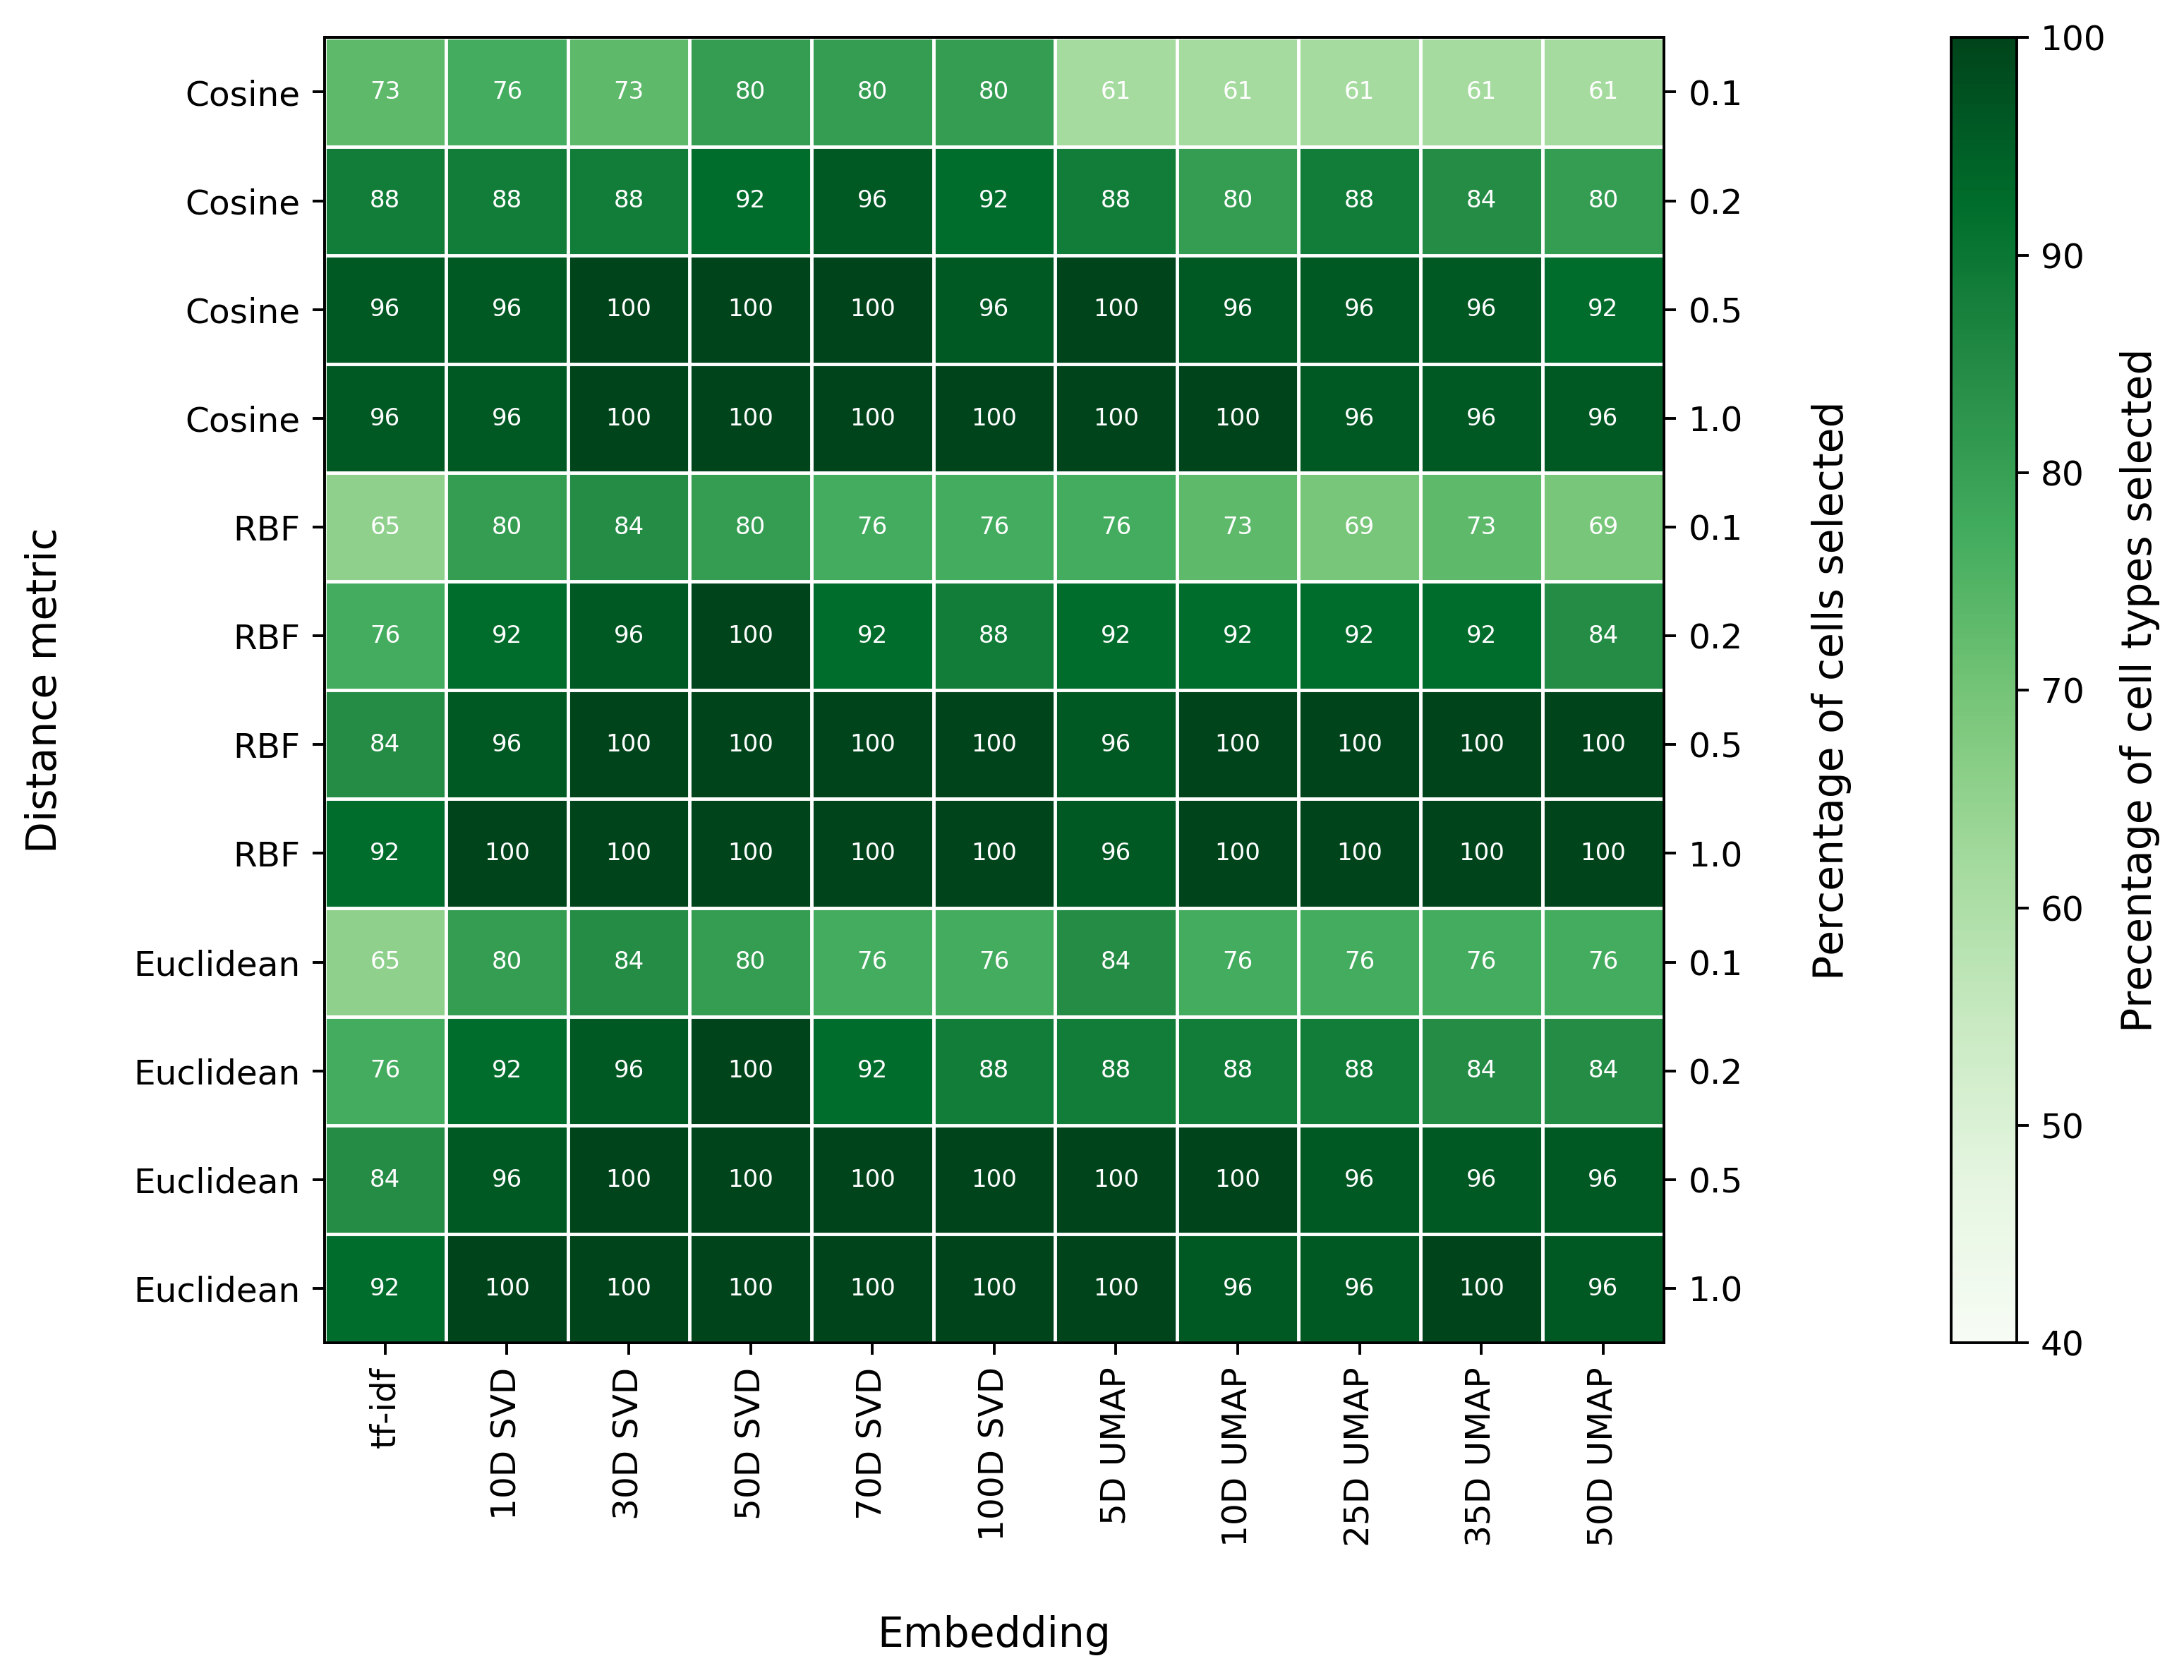

In [45]:
plt.figure(figsize=(10, 7), dpi=350)
plt.imshow(P_df.values * 100, vmin=40, vmax=100, cmap="Greens",
           aspect="auto")
cbar = plt.colorbar(pad=.15)
cbar.ax.set_ylabel("Precentage of cell types selected", fontsize=12)
ax = plt.gca()

nrows, ncols = P_df.shape

ax.set_xticks(range(ncols))
ax.set_xticklabels(xlabels, rotation=90)
ax.set_xlabel("Embedding", labelpad=20, fontsize=12)

ax.set_yticks(range(nrows))
ax.set_yticklabels(metrics)
ax.set_ylabel("Distance metric", labelpad=20, fontsize=12)

tickax = plt.gca().twinx()
tickax.imshow(P_df.values * 100, vmin=50, vmax=100, cmap="Greens",
              aspect="auto", zorder=-1)
tickax.set_yticks(range(nrows))
tickax.set_yticklabels(ncells)
tickax.set_ylabel("Percentage of cells selected", labelpad=20, fontsize=12)

# create text annotations
for i in range(nrows):
    for j in range(ncols):
        text = ax.text(j, i, int(P_df.iloc[i, j] * 100),
                       ha="center", va="center", color="w",
                       fontsize=7)

tickax.set_zorder(tickax.get_zorder()-1)

ax.set_xticks(np.arange(ncols+1)-.5, minor=True)
ax.set_yticks(np.arange(nrows+1)-.5, minor=True)
ax.grid(b=True, which="minor", axis="both", color="white", linestyle="-", linewidth=1)
ax.tick_params(which="minor", bottom=False, left=False)

plt.savefig("../figures/SEMITONES_cell_selection_type_retrieval.svg", dpi=300,
            bbox_inches="tight")

In [9]:
with open("SEMITONES_HD.pkl", "rb") as f:
    HD = pickle.load(f)
f.close()

In [10]:
pd.DataFrame(HD)

,umap35,umap10,umap50,tfidf,svd30,svd10,svd100,umap5,svd50,umap25,svd70
cosine_36,34.594985,35.148024,34.824153,32.770712,32.517970,35.433831,32.770712,34.735641,32.919458,34.862923,31.867840
cosine_75,34.371288,34.201059,34.331762,32.125013,32.169597,34.837631,31.811722,34.903338,31.876463,33.997396,31.568267
cosine_176,34.225647,34.339146,34.380951,32.125013,31.407601,35.403447,31.180852,34.617524,30.785610,33.751394,30.552530
cosine_352,34.128548,34.718172,34.169396,32.125013,31.024208,34.360957,30.421613,34.578549,30.594268,33.751394,30.988706
rbf_36,35.386902,34.946690,34.750070,32.546256,32.343035,36.007785,31.568267,35.187981,32.003113,35.367137,31.568267
rbf_75,34.344353,34.511750,34.756595,32.125013,31.112877,34.903822,30.440218,34.855742,30.433035,34.770873,30.433035
rbf_176,34.704099,30.402145,34.566231,32.125013,30.221854,34.578549,30.440218,30.318491,30.277107,30.600257,30.762454
rbf_352,34.371288,34.482775,32.309827,32.125013,30.557478,34.578549,30.421613,33.594001,30.673934,33.979716,30.334047
euclidean_36,36.207048,36.073878,35.330008,32.546256,32.343035,36.007785,31.568267,34.391137,32.003113,35.919188,31.568267
euclidean_75,34.243299,35.754090,35.330008,32.125013,31.112877,34.903822,30.440218,34.501884,30.433035,34.721892,30.433035


In [11]:
HD_df = pd.DataFrame(HD)

In [12]:
order = ["tfidf",
         "svd10", "svd30", "svd50", "svd70", "svd100",
         "umap5", "umap10", "umap25", "umap35", "umap50"]
xlabels = ["tf-idf",
           "10D SVD", "30D SVD", "50D SVD", "70D SVD", "100D SVD",
           "5D UMAP", "10D UMAP", "25D UMAP", "35D UMAP", "50D UMAP"]

In [16]:
ncells = [int(i.split("_")[1]) for i in HD_df.index]
ncells = [round(i / meta.shape[0], 3) * 100 for i in ncells]
metrics = [i.split("_")[0] for i in HD_df.index]
metrics = [i.title() if not i == "rbf" else "RBF" for i in metrics]

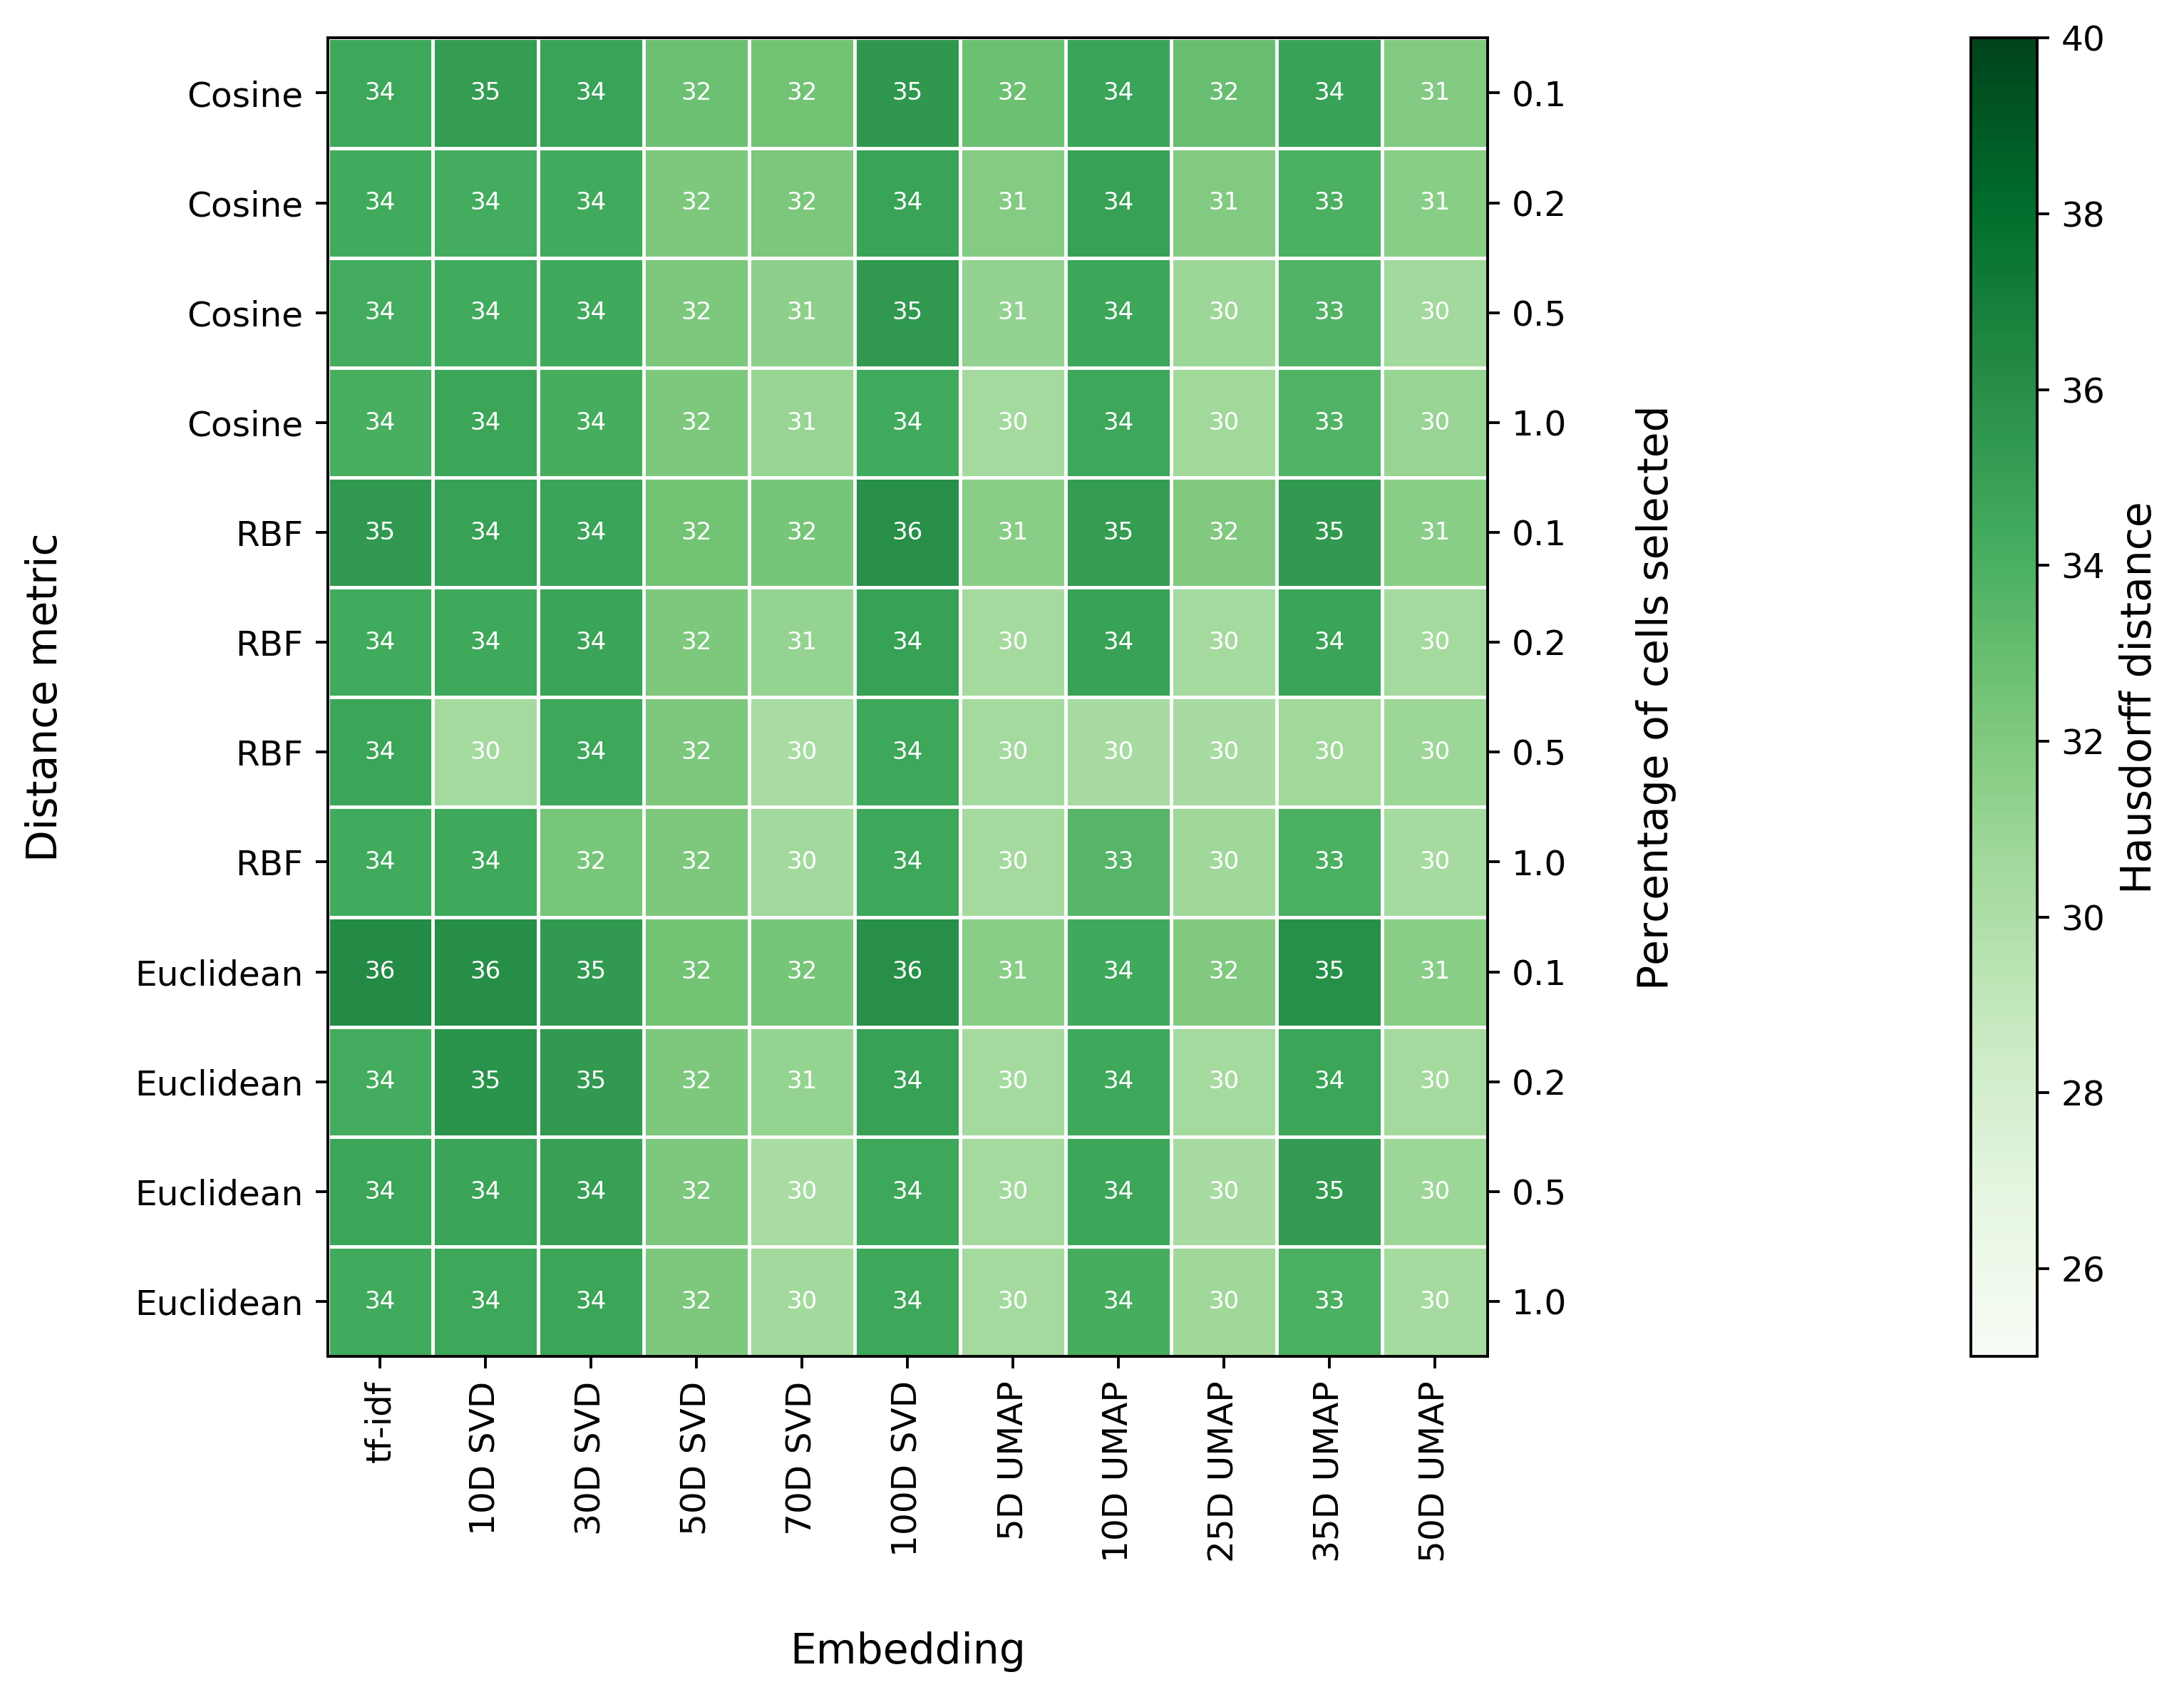

In [24]:
plt.figure(figsize=(10, 7), dpi=350)
plt.imshow(HD_df.values, vmin=25, vmax=40, cmap="Greens",
           aspect="auto")
cbar = plt.colorbar(pad=.25)
cbar.ax.set_ylabel("Hausdorff distance", fontsize=12)
ax = plt.gca()

nrows, ncols = HD_df.shape

ax.set_xticks(range(ncols))
ax.set_xticklabels(xlabels, rotation=90)
ax.set_xlabel("Embedding", labelpad=20, fontsize=12)

ax.set_yticks(range(nrows))
ax.set_yticklabels(metrics)
ax.set_ylabel("Distance metric", labelpad=20, fontsize=12)

tickax = plt.gca().twinx()
tickax.imshow(HD_df.values, vmin=25, vmax=40, cmap="Greens",
              aspect="auto", zorder=-1)
tickax.set_yticks(range(nrows))
tickax.set_yticklabels(ncells)
tickax.set_ylabel("Percentage of cells selected", labelpad=20, fontsize=12)

# create text annotations
for i in range(nrows):
    for j in range(ncols):
        text = ax.text(j, i, int(HD_df.iloc[i, j]),
                       ha="center", va="center", color="w",
                       fontsize=7)

tickax.set_zorder(tickax.get_zorder()-1)

ax.set_xticks(np.arange(ncols+1)-.5, minor=True)
ax.set_yticks(np.arange(nrows+1)-.5, minor=True)
ax.grid(b=True, which="minor", axis="both", color="white", linestyle="-", linewidth=1)
ax.tick_params(which="minor", bottom=False, left=False)

The Hausdorff distance, or Hausdorff metric, also called Pompeiu–Hausdorff distance,[1][2] measures how far two subsets of a metric space are from each other.